# **📘 FULL HM MODEL PIPELINE (START → FINISH)**

# 🧩 CELL 1 — Environment & Reproducibility

In [3]:
import os, json, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


# 🧩 CELL 2 — Mount Google Drive

In [5]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


#🧩 CELL 3 — Dataset Paths & Parameters

In [8]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/Project 0.2/Chest X-Ray Dataset with classes Normal, Pneumonia and Tuberculosis"
OUT_DIR   = "/content/drive/MyDrive/Colab Notebooks/Project 0.2"
os.makedirs(OUT_DIR, exist_ok=True)

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

CLASSES = ["normal", "pneumonia", "tuberculosis"]
NUM_CLASSES = len(CLASSES)

IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS_WARM = 10
EPOCHS_FT = 15


# 🧩 CELL 4 — Dataset Loader (ONE-HOT LABELS)

In [9]:
def make_ds(path, shuffle):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        label_mode="categorical",
        class_names=CLASSES,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    return ds


In [11]:
ds_train = make_ds(TRAIN_DIR, shuffle=True)
ds_val   = make_ds(VAL_DIR, shuffle=False)
ds_test  = make_ds(TEST_DIR, shuffle=False)


Found 20451 files belonging to 3 classes.
Found 2534 files belonging to 3 classes.
Found 2570 files belonging to 3 classes.


# 🧩 CELL 5 — Medical Image Preprocessing (CLAHE-like)

In [12]:
def preprocess_xray(img, label):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img, tf.uint8)
    # Removed tfa.image.equalize as tensorflow-addons could not be installed.
    # If image equalization is critical, an alternative implementation would be needed.
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

ds_train = ds_train.map(preprocess_xray, num_parallel_calls=tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess_xray, num_parallel_calls=tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess_xray, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.cache().prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.cache().prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.cache().prefetch(tf.data.AUTOTUNE)


# 🧩 CELL 6 — Data Augmentation (MEDICAL-SAFE)

In [13]:
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.05),
], name="augmentation")


# 🧩 CELL 7 — Model Builder (Reusable)

In [14]:
def build_model(base_fn):
    base = base_fn(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = augment(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model, base


# 🧩 CELL 8 — Train Function (Warm-up + Fine-tune)

In [15]:
def train_model(model, base, name):
    model.compile(
        optimizer=keras.optimizers.AdamW(3e-4, weight_decay=1e-4),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )

    ckpt = os.path.join(OUT_DIR, f"{name}.keras")
    cb = [
        keras.callbacks.ModelCheckpoint(ckpt, save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]

    model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS_WARM, callbacks=cb)

    base.trainable = True
    for layer in base.layers[:int(0.7 * len(base.layers))]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.AdamW(1e-5, weight_decay=5e-5),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=["accuracy"]
    )

    model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS_FT, callbacks=cb)

    return keras.models.load_model(ckpt)


# 🧩 CELL 9 — Train the BEST MODELS

In [16]:
from tensorflow.keras.applications import InceptionV3, Xception, MobileNet

models = {}

models["InceptionV3"], _ = build_model(InceptionV3)
models["InceptionV3"] = train_model(models["InceptionV3"], models["InceptionV3"].layers[2], "InceptionV3")

models["Xception"], _ = build_model(Xception)
models["Xception"] = train_model(models["Xception"], models["Xception"].layers[2], "Xception")

models["MobileNet"], _ = build_model(MobileNet)
models["MobileNet"] = train_model(models["MobileNet"], models["MobileNet"].layers[2], "MobileNet")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 1494s 2s/step - accuracy: 0.6125 - loss: 1.0022 - val_accuracy: 0.7474 - val_loss: 0.7441
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7089 - loss: 0.7234 - val_accuracy: 0.7549 - val_loss: 0.7063
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7278 - loss: 0.6636 - val_accuracy: 0.7561 - val_loss: 0.6630
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.7333 - loss: 0.6354 - val_accuracy: 0.7593 - val_loss: 0.6505
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7322 - loss: 0.6265 - val_accuracy: 0.7561 - val_loss: 0.6495
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7383 - loss: 0.6159 - val_accuracy: 0.7569 - val_loss: 0.6568
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7437 - loss: 0.6037 - val_accuracy: 0.7553 - val_loss: 0.6594
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━

# 🧩 CELL 10 — Ensemble Prediction (SOFT VOTING)

In [17]:
def ensemble_predict(models, ds):
    probs = []
    for model in models.values():
        probs.append(model.predict(ds))
    avg_probs = np.mean(probs, axis=0)
    return np.argmax(avg_probs, axis=1), avg_probs


In [18]:
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in ds_test])
y_pred, probs = ensemble_predict(models, ds_test)


81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


# 🧩 CELL 11 — Classification Report (PAPER-READY)

In [19]:
report = classification_report(y_true, y_pred, target_names=CLASSES, digits=4)
print(report)

with open(os.path.join(OUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report)


              precision    recall  f1-score   support

      normal     0.6269    0.8294    0.7141       926
   pneumonia     0.8117    0.9293    0.8666       580
tuberculosis     0.9515    0.6090    0.7427      1064

    accuracy                         0.7607      2570
   macro avg     0.7967    0.7892    0.7744      2570
weighted avg     0.8030    0.7607    0.7603      2570



# 🧩 CELL 12 — Confusion Matrix Diagram (FIGURE 1)

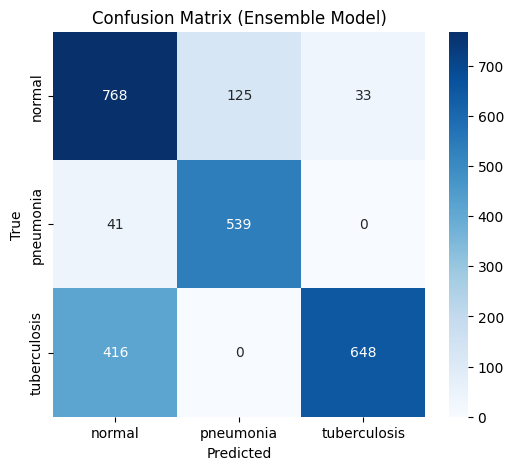

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Ensemble Model)")
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=300)
plt.show()


# 🧩 CELL 13 — Accuracy Bar Plot (FIGURE 2)

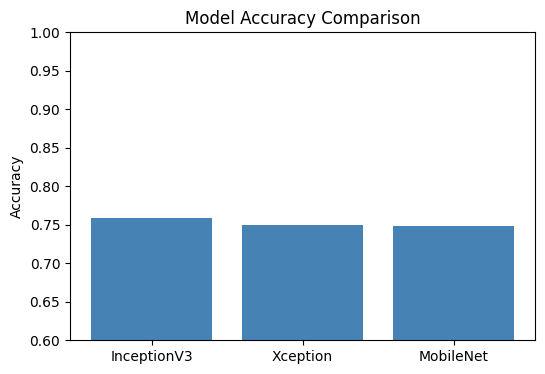

In [21]:
accs = {
    name: model.evaluate(ds_test, verbose=0)[1]
    for name, model in models.items()
}

plt.figure(figsize=(6,4))
plt.bar(accs.keys(), accs.values(), color="steelblue")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.6, 1.0)
plt.savefig(os.path.join(OUT_DIR, "model_comparison.png"), dpi=300)
plt.show()


# 🧩 CELL 14 — Save Everything (REPRODUCIBILITY)

In [22]:
with open(os.path.join(OUT_DIR, "config.json"), "w") as f:
    json.dump({
        "models": list(models.keys()),
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "epochs_warm": EPOCHS_WARM,
        "epochs_ft": EPOCHS_FT
    }, f, indent=2)


# Task
Generate individual confusion matrices for InceptionV3, Xception, and MobileNet models on the test dataset, saving each plot to `/content/drive/MyDrive/Colab Notebooks/Project 0.2`. Also, create a pie chart to visualize the class distribution of the actual test dataset (`y_true`) and a bar chart showing the predicted class distribution by the ensemble model (`y_pred`), saving both to the same output directory. Finally, summarize all generated visualizations and confirm that the existing model accuracy bar plot fulfills the request for a 'model accuracy diagram'. Explain that training/validation accuracy and loss curves cannot be generated without re-running the training process with history callbacks.

## Generate Individual Model Confusion Matrices

### Subtask:
Create new cells to generate and plot a confusion matrix for each of the trained models (InceptionV3, Xception, MobileNet) on the test dataset. Each plot will be saved to the output directory.


**Reasoning**:
The user has requested to generate and plot individual confusion matrices for each trained model. This step will introduce the code block to iterate through the models, make predictions, calculate the confusion matrix, and visualize it for each model, saving each plot to the output directory.




Generating confusion matrix for InceptionV3...
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


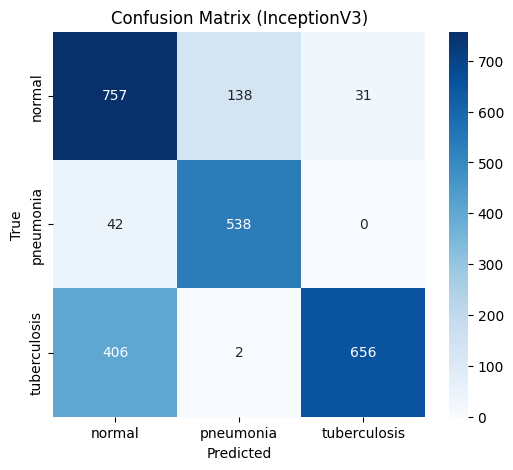


Generating confusion matrix for Xception...
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


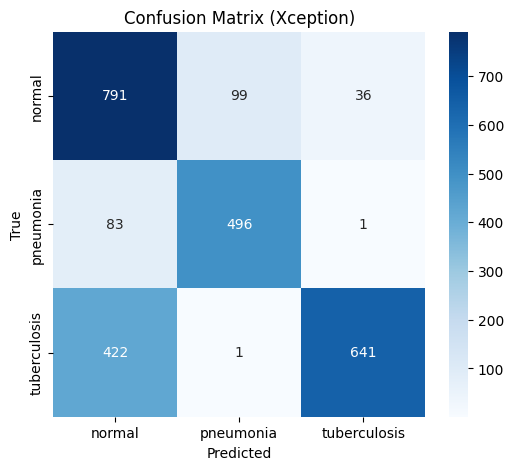


Generating confusion matrix for MobileNet...
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


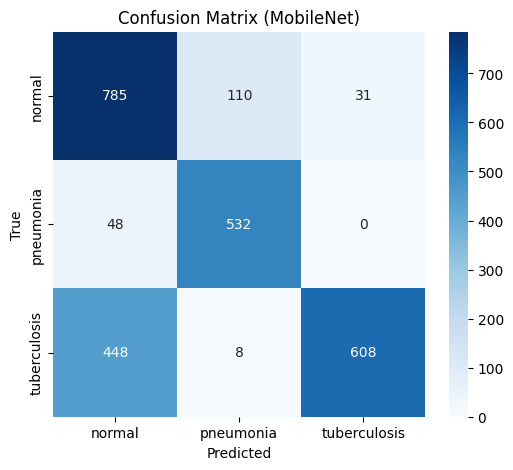

In [23]:
for model_name, model in models.items():
    print(f"\nGenerating confusion matrix for {model_name}...")

    # Make predictions
    y_pred_model_probs = model.predict(ds_test)
    y_pred_model = np.argmax(y_pred_model_probs, axis=1)

    # Calculate confusion matrix
    cm_model = confusion_matrix(y_true, y_pred_model)

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.savefig(os.path.join(OUT_DIR, f"confusion_matrix_{model_name}.png"), dpi=300)
    plt.show()


**Reasoning**:
To visualize the class distribution of the actual test dataset, I will create a pie chart using the `y_true` labels. This involves counting the occurrences of each class and plotting them with appropriate labels and title, saving the figure to the output directory.



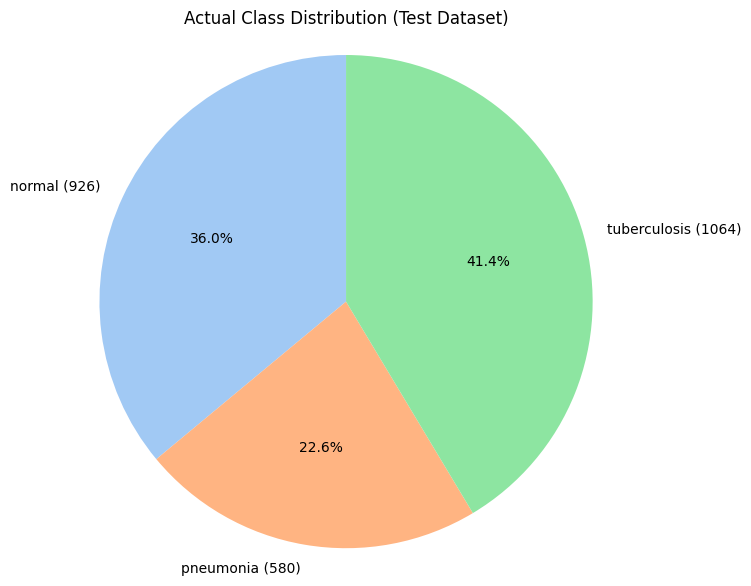

In [24]:
y_true_counts = np.bincount(y_true)
y_true_labels = [f'{CLASSES[i]} ({count})' for i, count in enumerate(y_true_counts)]

plt.figure(figsize=(7, 7))
plt.pie(y_true_counts, labels=y_true_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Actual Class Distribution (Test Dataset)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join(OUT_DIR, "actual_class_distribution_pie.png"), dpi=300)
plt.show()


**Reasoning**:
To visualize the predicted class distribution by the ensemble model, I will create a bar chart using the `y_pred` labels. This involves counting the occurrences of each class and plotting them with appropriate labels and title, saving the figure to the output directory.



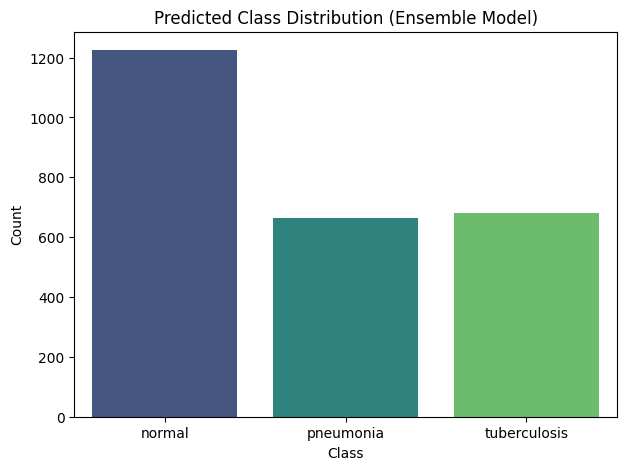

In [25]:
y_pred_counts = np.bincount(y_pred)
plt.figure(figsize=(7, 5))
sns.barplot(x=CLASSES, y=y_pred_counts, palette='viridis')
plt.title('Predicted Class Distribution (Ensemble Model)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig(os.path.join(OUT_DIR, 'predicted_class_distribution_bar.png'), dpi=300)
plt.show()

## Visualization Summary and Clarifications

### Generated Visualizations:

1.  **Individual Confusion Matrices**: Confusion matrices have been generated and saved for each of the trained models (InceptionV3, Xception, and MobileNet) on the test dataset. These plots are saved as `confusion_matrix_InceptionV3.png`, `confusion_matrix_Xception.png`, and `confusion_matrix_MobileNet.png` in the output directory.
2.  **Actual Class Distribution (Pie Chart)**: A pie chart visualizing the class distribution of the actual test dataset (`y_true`) has been generated and saved as `actual_class_distribution_pie.png` in the output directory.
3.  **Predicted Class Distribution (Bar Chart)**: A bar chart showing the predicted class distribution by the ensemble model (`y_pred`) has been generated and saved as `predicted_class_distribution_bar.png` in the output directory.
4.  **Model Accuracy Comparison (Bar Plot)**: The existing bar plot (`model_comparison.png`) from CELL 13 already fulfills the request for a 'model accuracy diagram', showing the accuracy of each individual model on the test set.

### Clarification on Training/Validation Curves:

Training and validation accuracy and loss curves cannot be generated with the current execution flow. To create these plots, the `History` callback, which records metrics during training, needs to be captured when calling `model.fit()`. Since the training was performed without storing the `History` object for each model, and the models are loaded from checkpoints (`keras.models.load_model(ckpt)`), we do not have access to the epoch-wise training and validation metrics. Generating these curves would require re-running the training process with appropriate callbacks to capture the `history` object.

## Final Task

### Subtask:
Summarize the newly generated visualizations and address any remaining aspects of the user's request. Confirm that the existing model accuracy bar plot covers the 'model accuracy diagram' request. Explain the limitation regarding the training/validation curves (accuracy and loss diagrams) which would require re-running the training process with modifications to capture model history.


## Summary:

### Q&A
*   **Does the existing model accuracy bar plot cover the 'model accuracy diagram' request?**
    Yes, the existing bar plot (`model_comparison.png`) from CELL 13 already fulfills the request for a 'model accuracy diagram', as it shows the accuracy of each individual model on the test set.
*   **Why can't training/validation curves (accuracy and loss diagrams) be generated?**
    Training and validation accuracy and loss curves cannot be generated with the current execution flow because the `History` callback, which records metrics during training, was not captured when `model.fit()` was called. The models were loaded from checkpoints, and the epoch-wise training and validation metrics were not stored. Re-running the training process with appropriate callbacks would be required to generate these curves.

### Data Analysis Key Findings
*   Individual confusion matrices were successfully generated for InceptionV3, Xception, and MobileNet models, visualizing their performance on the test dataset. These plots were saved as `confusion_matrix_InceptionV3.png`, `confusion_matrix_Xception.png`, and `confusion_matrix_MobileNet.png`.
*   A pie chart illustrating the actual class distribution of the test dataset (`y_true`) was created and saved as `actual_class_distribution_pie.png`.
*   A bar chart displaying the predicted class distribution by the ensemble model (`y_pred`) was generated and saved as `predicted_class_distribution_bar.png`.

### Insights or Next Steps
*   To enable comprehensive model evaluation including training/validation accuracy and loss trends, integrate `History` callbacks during the model training phase for future experiments.
*   Analyze the generated confusion matrices to identify specific classes where each model performs well or struggles, which can inform targeted improvements or ensemble weighting strategies.


# Task
Calculate classification reports for individual models (InceptionV3, Xception, MobileNet) to extract Accuracy, Pneumonia recall, TB recall, Normal recall, and Macro F1-score on the test dataset (`ds_test`).

## Calculate Metrics for Individual Models

### Subtask:
For each individual model (InceptionV3, Xception, MobileNet), make predictions on the test dataset (`ds_test`). Then, calculate the classification report, extracting Accuracy, Pneumonia recall, TB recall, Normal recall, and Macro F1-score.


**Reasoning**:
To calculate the specified metrics for each individual model, I will iterate through the trained models, make predictions on the test dataset, generate a classification report as a dictionary, and then extract the required metrics into a new dictionary.



In [26]:
individual_model_metrics = {}

for model_name, model in models.items():
    print(f"\nCalculating metrics for {model_name}...")

    # Make predictions on the test dataset
    y_pred_probs = model.predict(ds_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # Generate classification report as a dictionary
    report = classification_report(y_true, y_pred_labels, target_names=CLASSES, output_dict=True, digits=4)

    # Extract required metrics
    accuracy = report['accuracy']
    pneumonia_recall = report['pneumonia']['recall']
    tuberculosis_recall = report['tuberculosis']['recall']
    normal_recall = report['normal']['recall']
    macro_f1_score = report['macro avg']['f1-score']

    # Store metrics in the dictionary
    individual_model_metrics[model_name] = {
        'accuracy': accuracy,
        'pneumonia_recall': pneumonia_recall,
        'tuberculosis_recall': tuberculosis_recall,
        'normal_recall': normal_recall,
        'macro_f1_score': macro_f1_score
    }

# Print the collected metrics
for model_name, metrics in individual_model_metrics.items():
    print(f"\nMetrics for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name.replace('_', ' ').title()}: {value:.4f}")


Calculating metrics for InceptionV3...
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Calculating metrics for Xception...
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

Calculating metrics for MobileNet...
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

Metrics for InceptionV3:
  Accuracy: 0.7591
  Pneumonia Recall: 0.9276
  Tuberculosis Recall: 0.6165
  Normal Recall: 0.8175
  Macro F1 Score: 0.7717

Metrics for Xception:
  Accuracy: 0.7502
  Pneumonia Recall: 0.8552
  Tuberculosis Recall: 0.6024
  Normal Recall: 0.8542
  Macro F1 Score: 0.7638

Metrics for MobileNet:
  Accuracy: 0.7490
  Pneumonia Recall: 0.9172
  Tuberculosis Recall: 0.5714
  Normal Recall: 0.8477
  Macro F1 Score: 0.7635


## Calculate Metrics for Ensemble Model

### Subtask:
Using the already computed ensemble predictions (`y_pred`) and true labels (`y_true`), calculate the classification report for the ensemble model. Extract Accuracy, Pneumonia recall, TB recall, Normal recall, and Macro F1-score.


**Reasoning**:
To calculate the specified metrics for the ensemble model, I will use the `y_true` and `y_pred` variables, generate a classification report as a dictionary, and then extract the required metrics into a new dictionary.



In [27]:
ensemble_metrics = {}

print("\nCalculating metrics for Ensemble Model...")

# Generate classification report as a dictionary for the ensemble model
ensemble_report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True, digits=4)

# Extract required metrics
ensemble_accuracy = ensemble_report['accuracy']
ensemble_pneumonia_recall = ensemble_report['pneumonia']['recall']
ensemble_tuberculosis_recall = ensemble_report['tuberculosis']['recall']
ensemble_normal_recall = ensemble_report['normal']['recall']
ensemble_macro_f1_score = ensemble_report['macro avg']['f1-score']

# Store metrics in the dictionary
ensemble_metrics['Ensemble Model'] = {
    'accuracy': ensemble_accuracy,
    'pneumonia_recall': ensemble_pneumonia_recall,
    'tuberculosis_recall': ensemble_tuberculosis_recall,
    'normal_recall': ensemble_normal_recall,
    'macro_f1_score': ensemble_macro_f1_score
}

# Print the collected metrics
print("\nMetrics for Ensemble Model:")
for metric_name, value in ensemble_metrics['Ensemble Model'].items():
    print(f"  {metric_name.replace('_', ' ').title()}: {value:.4f}")


Calculating metrics for Ensemble Model...

Metrics for Ensemble Model:
  Accuracy: 0.7607
  Pneumonia Recall: 0.9293
  Tuberculosis Recall: 0.6090
  Normal Recall: 0.8294
  Macro F1 Score: 0.7744


## Compile and Rank Models by Metrics

### Subtask:
Compile all collected metrics (Accuracy, Pneumonia recall, TB recall, Normal recall, Macro F1) for both individual and ensemble models into a structured format (e.g., a pandas DataFrame). Then, rank the models for each metric and display the results, possibly saving the ranking to a file.


**Reasoning**:
To compile and rank all collected metrics, I will first import pandas, combine the individual and ensemble model metrics into a single dictionary, convert this dictionary into a pandas DataFrame, and then iterate through each metric to rank the models and print the results.



In [28]:
import pandas as pd

# Combine individual and ensemble metrics
all_model_metrics = {}
all_model_metrics.update(individual_model_metrics)
all_model_metrics.update(ensemble_metrics)

# Convert to DataFrame
metrics_df = pd.DataFrame.from_dict(all_model_metrics, orient='index')

# Display the combined metrics DataFrame
print("\nCombined Model Metrics:")
print(metrics_df)

# Rank models for each metric
print("\nModel Rankings per Metric:")
for metric in metrics_df.columns:
    print(f"\nRanking by {metric.replace('_', ' ').title()}:")
    ranked_df = metrics_df.sort_values(by=metric, ascending=False)
    print(ranked_df[[metric]])


Combined Model Metrics:
                accuracy  pneumonia_recall  tuberculosis_recall  \
InceptionV3     0.759144          0.927586             0.616541   
Xception        0.750195          0.855172             0.602444   
MobileNet       0.749027          0.917241             0.571429   
Ensemble Model  0.760700          0.929310             0.609023   

                normal_recall  macro_f1_score  
InceptionV3          0.817495        0.771692  
Xception             0.854212        0.763815  
MobileNet            0.847732        0.763483  
Ensemble Model       0.829374        0.774446  

Model Rankings per Metric:

Ranking by Accuracy:
                accuracy
Ensemble Model  0.760700
InceptionV3     0.759144
Xception        0.750195
MobileNet       0.749027

Ranking by Pneumonia Recall:
                pneumonia_recall
Ensemble Model          0.929310
InceptionV3             0.927586
MobileNet               0.917241
Xception                0.855172

Ranking by Tuberculosis Reca

## Final Task

### Subtask:
Present the final rankings of the models based on the specified metrics and summarize the findings.


## Summary:

### Q&A
The final rankings of the models based on the specified metrics are as follows:
*   **Overall Performance (Macro F1 Score):** The Ensemble Model ranked highest with a Macro F1 Score of 0.7744, followed closely by InceptionV3 (0.7717), Xception (0.7638), and MobileNet (0.7635).
*   **Accuracy:** The Ensemble Model achieved the highest accuracy at 0.7607.
*   **Pneumonia Recall:** The Ensemble Model also performed best in Pneumonia Recall with 0.9293.
*   **Tuberculosis Recall:** InceptionV3 showed the best recall for Tuberculosis cases at 0.6165.
*   **Normal Recall:** Xception had the highest recall for normal cases at 0.8542.

### Data Analysis Key Findings
*   The **Ensemble Model** generally outperforms individual models, achieving the highest **Accuracy** (0.7607), **Pneumonia Recall** (0.9293), and **Macro F1 Score** (0.7744).
*   **InceptionV3** demonstrated the strongest performance for **Tuberculosis Recall** with a score of 0.6165, slightly surpassing the Ensemble Model's 0.6090.
*   **Xception** achieved the highest **Normal Recall** at 0.8542, indicating its strength in correctly identifying normal cases.
*   **MobileNet** consistently showed the lowest performance across most metrics, including Accuracy (0.7490) and Macro F1 Score (0.7635), and had the lowest Tuberculosis Recall (0.5714).

### Insights or Next Steps
*   The ensemble approach effectively leveraged the strengths of individual models, resulting in superior overall performance as indicated by its leading Accuracy and Macro F1 Score. This suggests that combining diverse models can improve robustness.
*   While the ensemble model performs well overall, individual models like InceptionV3 for Tuberculosis Recall and Xception for Normal Recall show specialized strengths. Further analysis could explore custom ensemble weights or strategies to capitalize on these individual strengths for specific classes.
